In [1]:
import warnings

from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from nltk.tokenize.casual import casual_tokenize

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import (
    LatentDirichletAllocation,
    TruncatedSVD,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import (
    SVC,
    LinearSVC,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
)
from skopt import BayesSearchCV
from catboost import CatBoostClassifier


NGRAM_RANGE = (3,3)
N_SAMPLES = 20000
DATASET_PATH = "../data/stemming_post_texts.csv"

In [3]:
corpus_df = pd.read_csv(DATASET_PATH)

In [4]:
corpus_df.shape

(356565, 2)

In [5]:
corpus_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
train_corpus_df = corpus_df.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)

In [7]:
if N_SAMPLES:
    train_corpus_df = train_corpus_df.sample(N_SAMPLES)

In [8]:
text_documents_list = train_corpus_df.text.to_list()

In [9]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=NGRAM_RANGE, max_features=10000)

In [10]:
%%time
tf_idf_vectorizer.fit(text_documents_list)

CPU times: total: 5.12 s
Wall time: 5.33 s


TfidfVectorizer(max_features=10000, ngram_range=(3, 3),
                tokenizer=<function casual_tokenize at 0x000001D0E95E98B0>)

In [11]:
%%time
X = tf_idf_vectorizer.transform(train_corpus_df["text"])
y = train_corpus_df["sentiment"]

CPU times: total: 3.2 s
Wall time: 3.2 s


In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
X.shape

(20000, 10000)

SVD

In [14]:
svd_2_components = TruncatedSVD(n_components=2)

In [15]:
%%time
svd_2_components.fit(X)

CPU times: total: 46.9 ms
Wall time: 51 ms


TruncatedSVD()

In [16]:
svd_2_data = svd_2_components.transform(X)

In [17]:
svd_2_data_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
svd_2_data_df["sentiment"] = y
svd_2_data_df["sentiment"] = svd_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

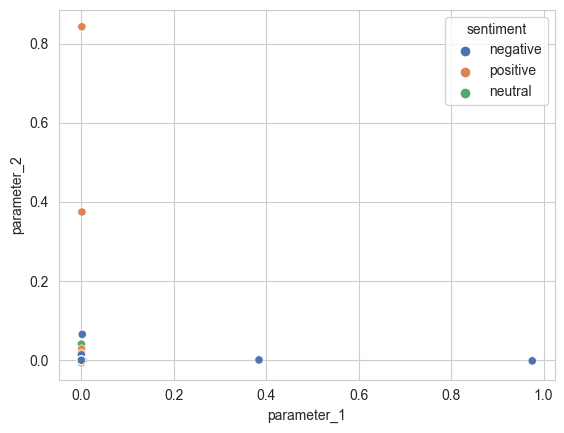

In [18]:
sns.scatterplot(data=svd_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

Latent Dirichlet Decomposition

In [19]:
ldia = LatentDirichletAllocation(n_components=2, learning_method="batch")

In [20]:
%%time
ldia.fit(X)

CPU times: total: 9.83 s
Wall time: 9.85 s


LatentDirichletAllocation(n_components=2)

In [21]:
ldia_2_data = ldia.transform(X)

In [22]:
ldia_2_data_df = pd.DataFrame(data=ldia_2_data, columns=["parameter_1", "parameter_2"])
ldia_2_data_df["sentiment"] = y
ldia_2_data_df["sentiment"] = ldia_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

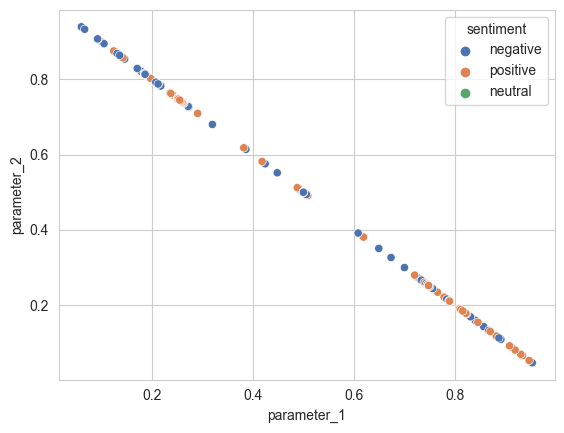

In [23]:
sns.scatterplot(data=ldia_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

K-means

In [24]:
k_means = KMeans(n_clusters=3, init="k-means++", max_iter=150)

In [25]:
%%time
k_means.fit(X)

CPU times: total: 4.72 s
Wall time: 1.28 s


KMeans(max_iter=150, n_clusters=3)

In [26]:
k_means_predictions = k_means.predict(X)

In [27]:
k_means_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
k_means_df["cluster"] = k_means_predictions
k_means_df["cluster"] = k_means_df["cluster"]

In [28]:
k_means_centers = pd.DataFrame(data=svd_2_components.transform(k_means.cluster_centers_), columns=["parameter_1", "parameter_2"])

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

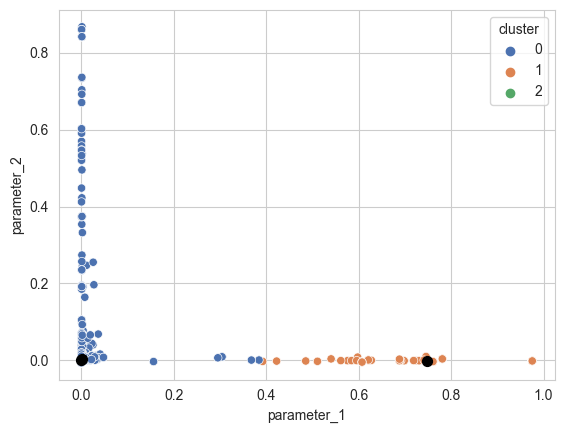

In [29]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=k_means_df, x="parameter_1", y="parameter_2",  hue="cluster", palette="deep")
k_means_centers.plot.scatter(x="parameter_1", y="parameter_2", ax=ax, s=50, color="black")

In [30]:
print(f"Однородность кластеров для K-средних: {homogeneity_score(y, k_means_df.cluster)}")
print(f"Полнота кластеров для K-средних: {completeness_score(y, k_means_df.cluster)}")
print(classification_report(y_encoded, k_means_df.cluster))

Однородность кластеров для K-средних: 0.001104175966514862
Полнота кластеров для K-средних: 0.034602699494087064
              precision    recall  f1-score   support

           0       0.43      0.99      0.60      8701
           1       0.00      0.00      0.00      1497
           2       0.67      0.00      0.00      9802

    accuracy                           0.43     20000
   macro avg       0.37      0.33      0.20     20000
weighted avg       0.52      0.43      0.26     20000



Разделение на обучающие и тестовые данные

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Наивный байесовский классификатор

In [32]:
naive_bayes_bcv = BayesSearchCV(estimator=MultinomialNB(), search_spaces={
    "alpha": [x / 10 for x in range(0, 11, 1)],
    "fit_prior": [True, False],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [33]:
%%time
naive_bayes_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=MultinomialNB(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                       0.8, 0.9, 1.0],
                             'fit_prior': [True, False]},
              verbose=2)

In [34]:
naive_bayes_model = naive_bayes_bcv.best_estimator_

In [35]:
naive_bayes_model

MultinomialNB(alpha=0.0)

In [36]:
y_pred = naive_bayes_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.57      0.10      0.17      1748
     neutral       0.52      0.22      0.31       294
    positive       0.52      0.95      0.67      1958

    accuracy                           0.52      4000
   macro avg       0.54      0.42      0.38      4000
weighted avg       0.54      0.52      0.43      4000



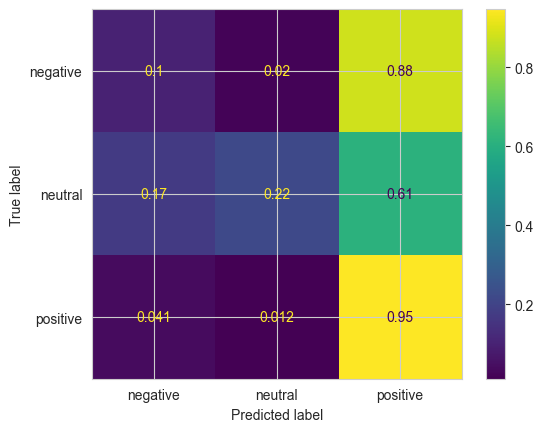

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [38]:
print(np.mean(cross_val_score(naive_bayes_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.4221486650741757


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


SVC

In [39]:
%%time

svc_bcv = BayesSearchCV(estimator=SVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=SVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [40]:
svc = svc_bcv.best_estimator_
svc

SVC(C=0.4, max_iter=740)

In [41]:
%%time
svc.fit(X_train, y_train)

CPU times: total: 625 ms
Wall time: 612 ms


SVC(C=0.4, max_iter=740)

In [42]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.49      0.05      0.09      1748
     neutral       0.17      0.38      0.24       294
    positive       0.50      0.81      0.62      1958

    accuracy                           0.45      4000
   macro avg       0.39      0.41      0.32      4000
weighted avg       0.47      0.45      0.36      4000



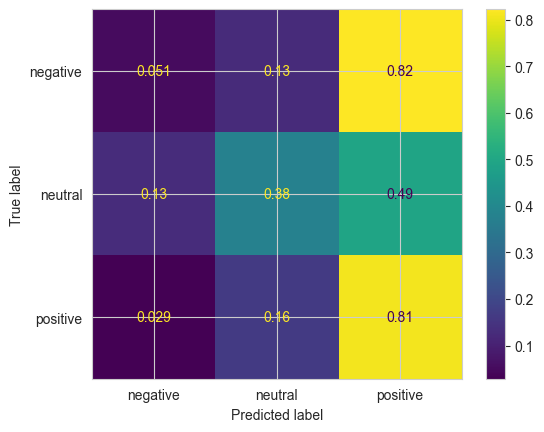

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [44]:
print(np.mean(cross_val_score(svc, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.40671923867636045


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished


LinearSVC

In [45]:
%%time

linear_svc_bcv = BayesSearchCV(estimator=LinearSVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
    "loss": ["hinge", "squared_hinge"],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

linear_svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=LinearSVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'loss': ['hinge', 'squared_hinge'],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [46]:
linear_svc_model = linear_svc_bcv.best_estimator_
linear_svc_model

LinearSVC(C=0.8, max_iter=10)

In [47]:
%%time
linear_svc_model.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 15 ms


LinearSVC(C=0.8, max_iter=10)

In [48]:
y_pred = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.54      0.10      0.16      1748
     neutral       0.52      0.13      0.20       294
    positive       0.51      0.95      0.67      1958

    accuracy                           0.52      4000
   macro avg       0.53      0.39      0.34      4000
weighted avg       0.53      0.52      0.41      4000



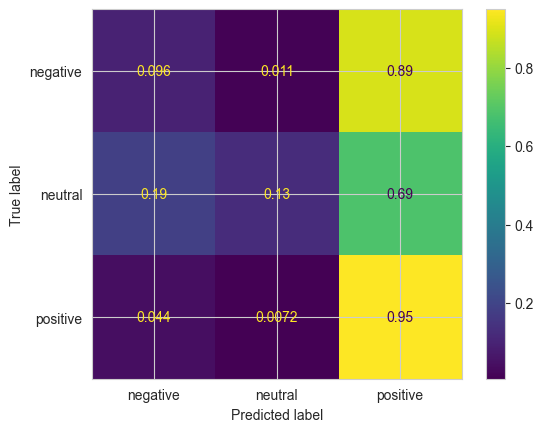

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [50]:
print(np.mean(cross_val_score(linear_svc_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.38236303861549475


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Логистическая регрессия

In [51]:
log_reg = LogisticRegression()

In [52]:
%%time
log_reg.fit(X_train, y_train)

CPU times: total: 2.64 s
Wall time: 472 ms


LogisticRegression()

In [53]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.55      0.10      0.17      1748
     neutral       0.60      0.02      0.04       294
    positive       0.51      0.96      0.66      1958

    accuracy                           0.51      4000
   macro avg       0.55      0.36      0.29      4000
weighted avg       0.53      0.51      0.40      4000



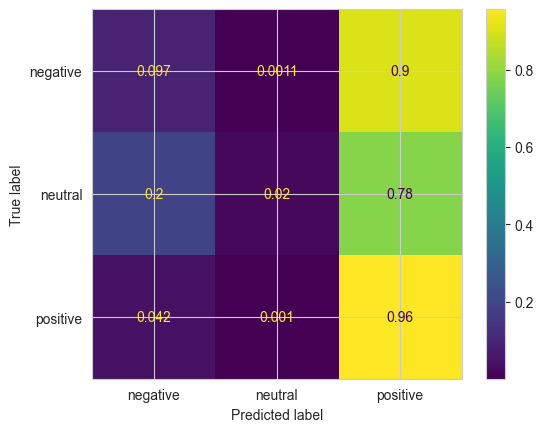

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [55]:
print(np.mean(cross_val_score(log_reg, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.3751828441817122


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.2s finished


K-ближайших соседей

In [56]:
knn_bcv = BayesSearchCV(estimator=KNeighborsClassifier(), search_spaces={
    "n_neighbors": [n for n in range(1, 21, 1)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [57]:
%%time
knn_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=KNeighborsClassifier(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19,
                                             20]},
              verbose=2)

In [58]:
knn_model = knn_bcv.best_estimator_

In [59]:
knn_model

KNeighborsClassifier(n_neighbors=1)

In [60]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.57      0.08      0.13      1748
     neutral       0.44      0.09      0.15       294
    positive       0.50      0.95      0.66      1958

    accuracy                           0.51      4000
   macro avg       0.51      0.37      0.31      4000
weighted avg       0.53      0.51      0.39      4000



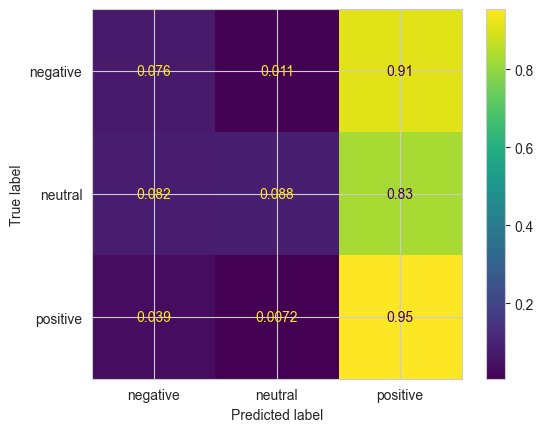

In [61]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [62]:
print(np.mean(cross_val_score(knn_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.35662537018686935


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Дерево решений

In [63]:
d_tree_bcv = BayesSearchCV(estimator=DecisionTreeClassifier(), search_spaces={
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [depth for depth in range(2, 500, 10)]
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [64]:
%%time
d_tree_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
              scoring='f1_weighted',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [2, 12, 22, 32, 42, 52, 62, 72, 82,
                                           92, 102, 112, 122, 132, 142, 152,
                                           162, 172, 182, 192, 202, 212, 222,
                                           232, 242, 252, 262, 272, 282, 292, ...],
                             'splitter': ['best', 'random']},
              verbose=2)

In [65]:
d_tree_model = d_tree_bcv.best_estimator_

In [66]:
d_tree_model

DecisionTreeClassifier(criterion='entropy', max_depth=492, splitter='random')

In [67]:
y_pred = d_tree_model.predict(X_test)
print(classification_report(y_test, d_tree_model.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.66      0.04      0.07      1748
     neutral       0.45      0.14      0.21       294
    positive       0.50      0.98      0.66      1958

    accuracy                           0.51      4000
   macro avg       0.54      0.38      0.32      4000
weighted avg       0.57      0.51      0.37      4000



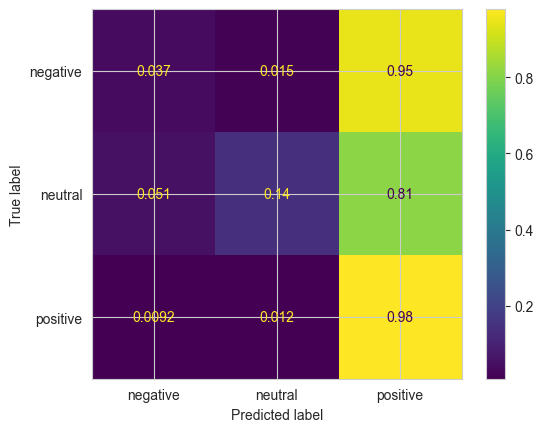

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [69]:
print(np.mean(cross_val_score(d_tree_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.3714683127982192


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.9s finished


Градиентный бустинг (CatBoost)

In [70]:
catboost_model = CatBoostClassifier(
    task_type="CPU",
    iterations=5000,
    od_wait=300,
    od_type="Iter",
    learning_rate=0.5,
    eval_metric="TotalF1",
)

In [71]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)

In [72]:
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), verbose=100, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3238016	test: 0.3229740	best: 0.3229740 (0)	total: 188ms	remaining: 15m 39s
100:	learn: 0.3809623	test: 0.3538670	best: 0.3541784 (85)	total: 5.52s	remaining: 4m 27s
200:	learn: 0.4087090	test: 0.3633574	best: 0.3634678 (187)	total: 10.6s	remaining: 4m 12s
300:	learn: 0.4332282	test: 0.3729884	best: 0.3729884 (298)	total: 15.8s	remaining: 4m 6s
400:	learn: 0.4511222	test: 0.3776460	best: 0.3776460 (397)	total: 20.9s	remaining: 4m
500:	learn: 0.4673523	test: 0.3845907	best: 0.3845907 (496)	total: 26.2s	remaining: 3m 55s
600:	learn: 0.4812294	test: 0.3892453	best: 0.3892453 (600)	total: 31.2s	remaining: 3m 48s
700:	learn: 0.4963196	test: 0.3951844	best: 0.3951844 (692)	total: 36.5s	remaining: 3m 43s
800:	learn: 0.5072491	test: 0.3950734	best: 0.3965812 (737)	total: 41.6s	remaining: 3m 37s
900:	learn: 0.5144357	test: 0.4003539	best: 0.4003539 (900)	total: 47s	remaining: 3m 33s
1000:	learn: 0.5190796	test: 0.4026567	best: 0.4028382 (990)	total: 52.2s	remaining: 3m 28s
1100:	lea

In [73]:
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.56      0.08      0.13      1748
     neutral       0.57      0.11      0.19       294
    positive       0.51      0.96      0.67      1958

    accuracy                           0.51      4000
   macro avg       0.55      0.38      0.33      4000
weighted avg       0.53      0.51      0.40      4000



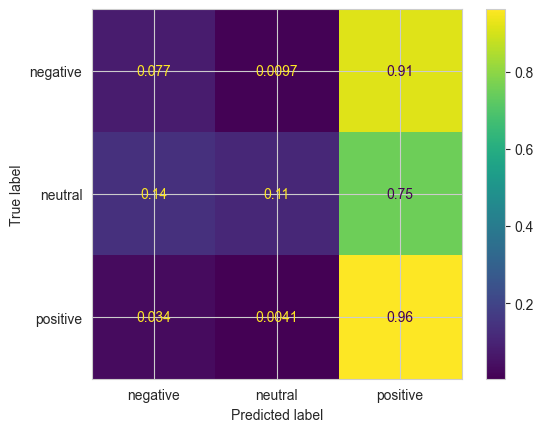

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()